In [2]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder


import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

sns.set_theme()


## Загрузка данных

Загрузим данные из CSV файла

In [3]:
df = pd.read_csv('adult.csv', header=None)
df.columns = [
    'age',            'workclass',      'fnlwgt',       'education',
    'education_num',  'martial_status', 'ocupation',    'relationship',
    'race',           'sex',            'capital_gain', 'capital_loss',
    'hours_per_week', 'native_country', 'income'
]
df.head()

,age,workclass,fnlwgt,education,education_num,martial_status,ocupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
print(df.shape)

(32561, 15)


Посмотрим, если у нас пропуски в данных и какие типы данных у нас загрузились по умолчанию

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   martial_status  32561 non-null  object
 6   ocupation       32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Явных пропусков нет, а типы данных соответсвуют ожиданиям.

## EDA

In [91]:
df['income'].value_counts()

 <=50K    24720
 >50K      7841
Name: income, dtype: int64

Дисбаланс классов?

### Распрделение дохода в зависимости от продолжительности обучения

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


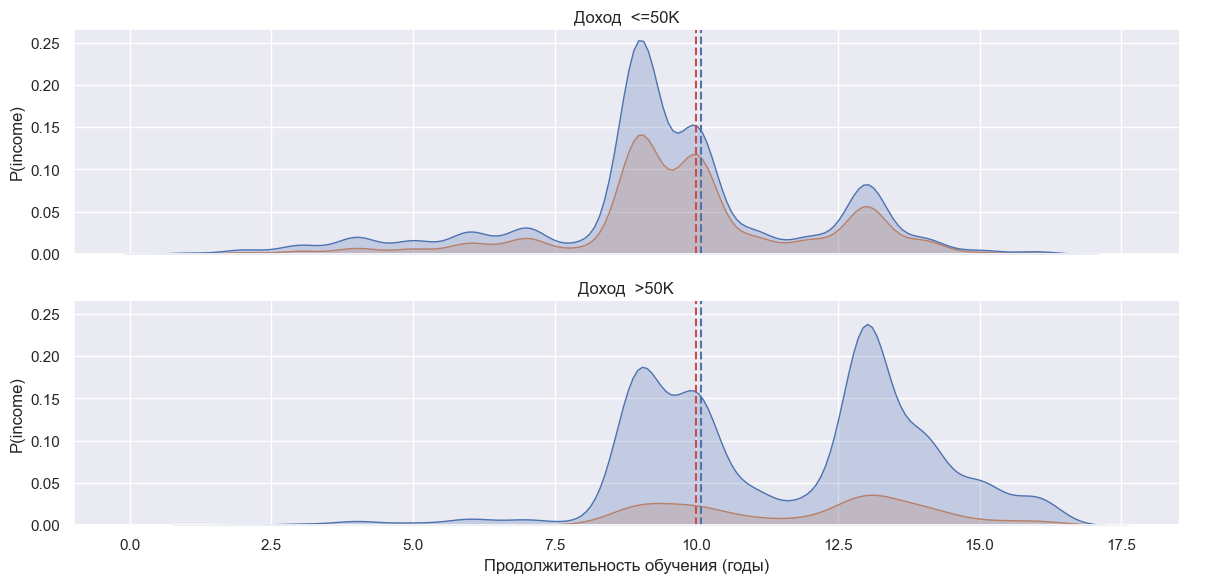

In [129]:
g = sns.FacetGrid(df, row='income', aspect=4)
g.map_dataframe( sns.kdeplot, x='education_num', hue='sex', fill=True)
g.refline(x=df['education_num'].mean(),   color='b')
g.refline(x=df['education_num'].median(), color='r')
g.set_titles('Доход {row_name}')
g.set_axis_labels("Продолжительность обучения (годы)", "P(income)")
g.add_legend()

## Подготовка датасета

In [938]:
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import FeatureUnion, FunctionTransformer, make_pipeline, make_union
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder

oe = OrdinalEncoder()

X = df.iloc[:,:-1]
y = oe.fit_transform(df[['income']])

print('X', X.shape, 'Y', y.shape)

# Засунем все в наш пайплайн
features = make_column_transformer(
    (MinMaxScaler(), ['age', 'hours_per_week', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss']),
    (OneHotEncoder( handle_unknown='ignore' ),  ['workclass', 'education', 'martial_status', 'ocupation', 'relationship', 'race', 'sex', 'native_country']),
    remainder='drop',
    verbose_feature_names_out=True
)

# TTS
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), train_size=.8, test_size=.2, random_state=31337)

for clsf in [
    LogisticRegression( max_iter=800, fit_intercept=True, penalty=None), 
    LogisticRegression( max_iter=800, fit_intercept=True, solver='liblinear', penalty='l1'),
    LogisticRegression( max_iter=800, fit_intercept=True, solver='liblinear', penalty='l2'), 
    SVC(),
    SVC(kernel='linear'), 
    SVC(kernel='poly')
]:
    print('=====================================================')
    p = Pipeline(steps=[('features', features), ('clsf', clsf) ])
    print(clsf)
    p.fit(X_train, y_train)
    print('TRAIN =', p.score(X_train, y_train), '; TEST =', p.score(X_test,  y_test))





X (32561, 14) Y (32561, 1)
LogisticRegression(max_iter=800, penalty=None)
TRAIN = 0.8541922604422605 ; TEST = 0.8510670965760786
LogisticRegression(max_iter=800, penalty='l1', solver='liblinear')
TRAIN = 0.8544993857493858 ; TEST = 0.8516812528788577
LogisticRegression(max_iter=800, solver='liblinear')
TRAIN = 0.8521575552825553 ; TEST = 0.8492246276677414
SVC()
TRAIN = 0.8466292997542998 ; TEST = 0.8278826961461692
SVC(kernel='linear')
TRAIN = 0.8530789312039312 ; TEST = 0.8458467680024566
SVC(kernel='poly')
TRAIN = 0.8528869778869779 ; TEST = 0.8298787041302012


## Выводы

1. Обучение и вывод с помощью SVM происходит продолжительное время, при этом score не значительно выше (а иногда и ниже) обычной логистической регрессии.
2. Использование MinMaxScaler (вместо StandardScaler) позволило добиться дополнительных 1-2% точности.